## Historical Price Data EDA

In [1]:
import os
os.chdir(os.environ['PWD'])

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from conf import settings as sts
from conf import utils as uts
from unidecode import unidecode
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
import string
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import LinearRegression

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felipegonzalez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Import Historical Data

In [3]:
dataset = pd.read_csv(sts.LOCAL_DATA_PATH+sts.FINAL_PRICE_DATASET)

In [4]:
dataset.shape

(554550, 5)

In [5]:
dataset.head()

,date,group,product,market,mean_price
0,2013-01-01,VERDURAS Y HORTALIZAS,Pepino cohombro,"Cúcuta, Cenabastos",790.0
1,2013-01-01,PROCESADOS,Galletas dulces redondas con crema,"Bucaramanga, Centroabastos",9281.0
2,2013-01-01,PROCESADOS,Galletas dulces redondas con crema,"Bucaramanga, Mercados del centro",9446.0
3,2013-01-01,PROCESADOS,Galletas dulces redondas con crema,"Cartagena, Bazurto",8591.0
4,2013-01-01,PROCESADOS,Galletas dulces redondas con crema,"Cúcuta, Cenabastos",9558.0


In [6]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [7]:
dataset['date'].describe(datetime_is_numeric=True)

count                           554550
mean     2017-11-23 10:41:51.761969152
min                2013-01-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-12-01 00:00:00
75%                2020-05-01 00:00:00
max                2022-11-01 00:00:00
Name: date, dtype: object

#### Preprocess Text Data

In [8]:
def clean_text(text):
    clean_text = unidecode(text.lower())
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    clean_text = ' '.join(word_tokenize(clean_text))
    return clean_text

In [9]:
dataset['group'] = dataset['group'].apply(clean_text)
dataset['product'] = dataset['product'].apply(clean_text)

In [10]:
dataset['department'] = dataset['market'].str.split(',',expand=True)[0]

In [ ]:
dataset['market'] = dataset['market'].apply(clean_text)
dataset['department'] = dataset['department'].apply(clean_text)

#### Class Descriptions

In [ ]:
dataset['group'].value_counts()

frutas                          140634
verduras y hortalizas           113260
carnes                           87006
procesados                       81227
tuberculos raices y platanos     45244
granos y cereales                35701
pescados                         26749
lacteos y huevos                 24729
Name: group, dtype: int64

In [ ]:
dataset['product'].value_counts().head(20)

tomate de arbol            5365
pimenton                   5189
habichuela                 4945
papa criolla limpia        4873
cilantro                   4729
mora de castilla           4704
pepino cohombro            4621
platano harton verde       4618
lechuga batavia            4594
chocolo mazorca            4483
manzana verde importada    4454
lulo                       4382
manzana roja importada     4277
guayaba pera               4149
lenteja importada          4112
papaya maradol             4106
banano criollo             4055
arveja verde en vaina      4014
pera importada             3985
maracuya                   3929
Name: product, dtype: int64

In [ ]:
sorted(dataset['product'].unique())

['aceite de palma',
 'aceite girasol',
 'aceite soya',
 'aceite vegetal mezcla',
 'acelga',
 'aguacate comun',
 'aguacate hass',
 'aguacate papelillo',
 'ahuyama',
 'ahuyamin sakata',
 'aji topito dulce',
 'ajo',
 'ajo importado',
 'alas de pollo con costillar',
 'alas de pollo sin costillar',
 'almejas con concha',
 'almejas sin concha',
 'apio',
 'arracacha amarilla',
 'arracacha blanca',
 'arroz blanco importado',
 'arroz de primera',
 'arroz de segunda',
 'arroz excelso',
 'arroz sopa cristal',
 'arveja amarilla seca importada',
 'arveja enlatada',
 'arveja verde en vaina',
 'arveja verde en vaina pastusa',
 'arveja verde seca importada',
 'avena en hojuelas',
 'avena molida',
 'azucar morena',
 'azucar refinada',
 'azucar sulfitada',
 'badea',
 'bagre rayado en postas congelado',
 'bagre rayado entero congelado',
 'bagre rayado entero fresco',
 'banano bocadillo',
 'banano criollo',
 'banano uraba',
 'basa entero congelado importado',
 'basa filete congelado importado',
 'berenjen

In [ ]:
dataset['market'].value_counts()

medellin central mayorista de antioquia     25406
bogota dc corabastos                        20050
cucuta cenabastos                           17352
ibague plaza la 21                          16450
barranquilla barranquillita                 15654
                                            ...  
san sebastian de mariquita tolima panela        3
barranquilla molino gran senora                 2
barranquilla molino el litoral                  2
barranquilla inversiones lache                  2
socorro santander panela                        2
Name: market, Length: 102, dtype: int64

In [ ]:
dataset['department'].value_counts()

bogota                               45290
medellin                             39546
cali                                 36971
barranquilla                         25934
cucuta                               24047
                                     ...  
san andres de tumaco narino             61
san sebastian de mariquita tolima       59
malambo                                 46
san marcos                              28
la parada norte de santander            22
Name: department, Length: 69, dtype: int64

In [17]:
dataset.to_csv(sts.LOCAL_DATA_PATH+"final_prices_dataset_clean.csv", index=False)

In [18]:
dataset = pd.read_csv(sts.LOCAL_DATA_PATH+"final_prices_dataset_clean.csv")

In [25]:
dataset['date'] = pd.to_datetime(dataset['date'])

## Time Series Analysis

In [26]:
date_range = pd.date_range(start = dataset['date'].min(), end = dataset['date'].max(), freq = 'MS')

In [27]:
selected_markets = [
    'medellin central mayorista de antioquia', 
    'bogota dc corabastos',
    'cucuta cenabastos',
    'barranquilla barranquillita'
                   ]

In [28]:
selected_product = 'manzana roja importada'

In [29]:
filter_key = (dataset['market'].isin(selected_markets)) & (dataset['product']==selected_product)

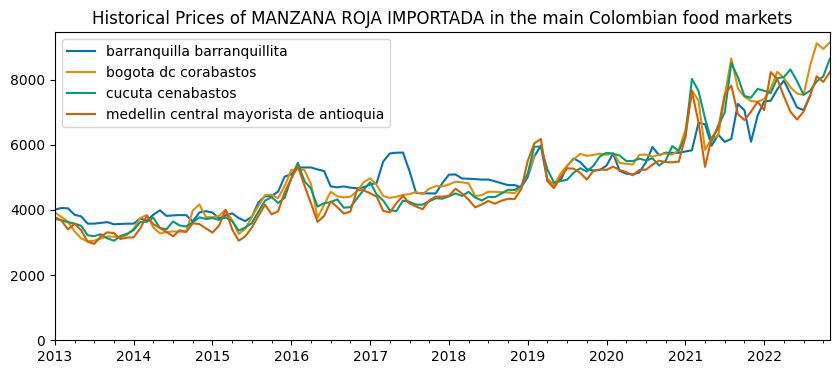

In [30]:
plt.figure(figsize=(10,4))
for key, df_key in dataset.loc[filter_key].groupby('market'):
    price_series = df_key.set_index(['date']).reindex(date_range)
    price_series['mean_price'].plot(label=key)
plt.ylim(bottom=0)
plt.title(f"Historical Prices of {selected_product.upper()} in the main Colombian food markets")
plt.legend()
plt.show()

In [31]:
dataset_pivot = dataset.pivot(index='date', columns = ['group', 'product', 'market'], values = 'mean_price')

In [32]:
dataset_pivot = dataset_pivot.reindex(date_range)